# End-to-End Delivery Duration Prediction Project

## 1. Project Overview

**Objective**: Predict total delivery duration in seconds from order creation to delivery completion.

**Target Variable**: `actual_delivery_time` - `created_at` (in seconds)

**Business Impact**: Accurate delivery time predictions significantly improve customer experience and operational efficiency.

## 2. Data Understanding & Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# This cell downloads the data if it's not already present.
from pathlib import Path
my_file = Path("historical_data.csv")
if my_file.is_file() == False:
  !wget 'https://raw.githubusercontent.com/ChetanParmarHQ/DoorDash-Delivery-Duration-Prediction/refs/heads/main/historical_data.csv'

# Load data
try:
    df = pd.read_csv('historical_data.csv')
except FileNotFoundError:
    print("Make sure 'historical_data.csv' is in the same directory.")
    # As a fallback, create a dummy dataframe to allow the notebook to run
    # df = pd.DataFrame()

# Basic info
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (197428, 16)

Columns: ['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']

Data types:
market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                         

In [3]:
# 1. Handle missing values strategically
print("\n=== Missing Values Analysis ===")
missing_percent = (df.isnull().sum() / len(df)) * 100
print("Missing values percentage:")
print(missing_percent.sort_values(ascending=False))

# 2. Convert data types
print("\n=== Converting Data Types ===")
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

# Convert to categorical where appropriate
df['market_id'] = df['market_id'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')
df['store_primary_category'] = df['store_primary_category'].astype('category')

print("Updated data types:")
print(df.dtypes)

# 3. Check for invalid datetime conversions
print(f"\nInvalid created_at timestamps: {df['created_at'].isnull().sum()}")
print(f"Invalid delivery timestamps: {df['actual_delivery_time'].isnull().sum()}")

# 4. Create target variable and validate
df = df.dropna(subset=['created_at', 'actual_delivery_time'])  # Remove rows with invalid timestamps
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

# Remove unrealistic delivery times
original_count = len(df)
df = df[(df['delivery_duration'] > 60) & (df['delivery_duration'] < 3600*3)]  # 1 min to 3 hours
print(f"\nRemoved {original_count - len(df)} rows with unrealistic delivery times")
print(f"Final dataset shape: {df.shape}")

# 5. Basic target variable analysis
print("\n=== Target Variable Analysis ===")
print(f"Delivery duration stats (seconds):")
print(f"Min: {df['delivery_duration'].min():.0f}")
print(f"Max: {df['delivery_duration'].max():.0f}")
print(f"Mean: {df['delivery_duration'].mean():.0f}")
print(f"Median: {df['delivery_duration'].median():.0f}")


=== Missing Values Analysis ===
Missing values percentage:
total_busy_dashers                              8.236927
total_outstanding_orders                        8.236927
total_onshift_dashers                           8.236927
store_primary_category                          2.411006
order_protocol                                  0.503981
market_id                                       0.499929
estimated_store_to_consumer_driving_duration    0.266426
actual_delivery_time                            0.003546
subtotal                                        0.000000
total_items                                     0.000000
created_at                                      0.000000
store_id                                        0.000000
max_item_price                                  0.000000
min_item_price                                  0.000000
num_distinct_items                              0.000000
estimated_order_place_duration                  0.000000
dtype: float64

=== Converti

### 2.1. Target Variable Creation

In [4]:
# Convert time columns to datetime objects
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Calculate target variable
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

# Remove unrealistic values (e.g., negative or extremely long deliveries)
# Assuming a reasonable max delivery time of 2 hours (7200 seconds) and min of 5 mins (300 seconds)
df = df[(df['delivery_duration'] >= 300) & (df['delivery_duration'] <= 7200)].copy()

print(f"Target statistics (in seconds):\n{df['delivery_duration'].describe()}")

Target statistics (in seconds):
count    196328.000000
mean       2825.902576
std        1015.830730
min         321.000000
25%        2101.000000
50%        2653.000000
75%        3365.000000
max        7196.000000
Name: delivery_duration, dtype: float64


### 2.2. Target Variable Transformation

The initial distribution of `delivery_duration` was highly right-skewed, which can be problematic for linear models.

I applied a log-transform (`np.log1p`) to normalize the distribution. This new `log_delivery_duration` will be the target variable (`y`). Predictions will be transformed back using `np.expm1()` for final evaluation.

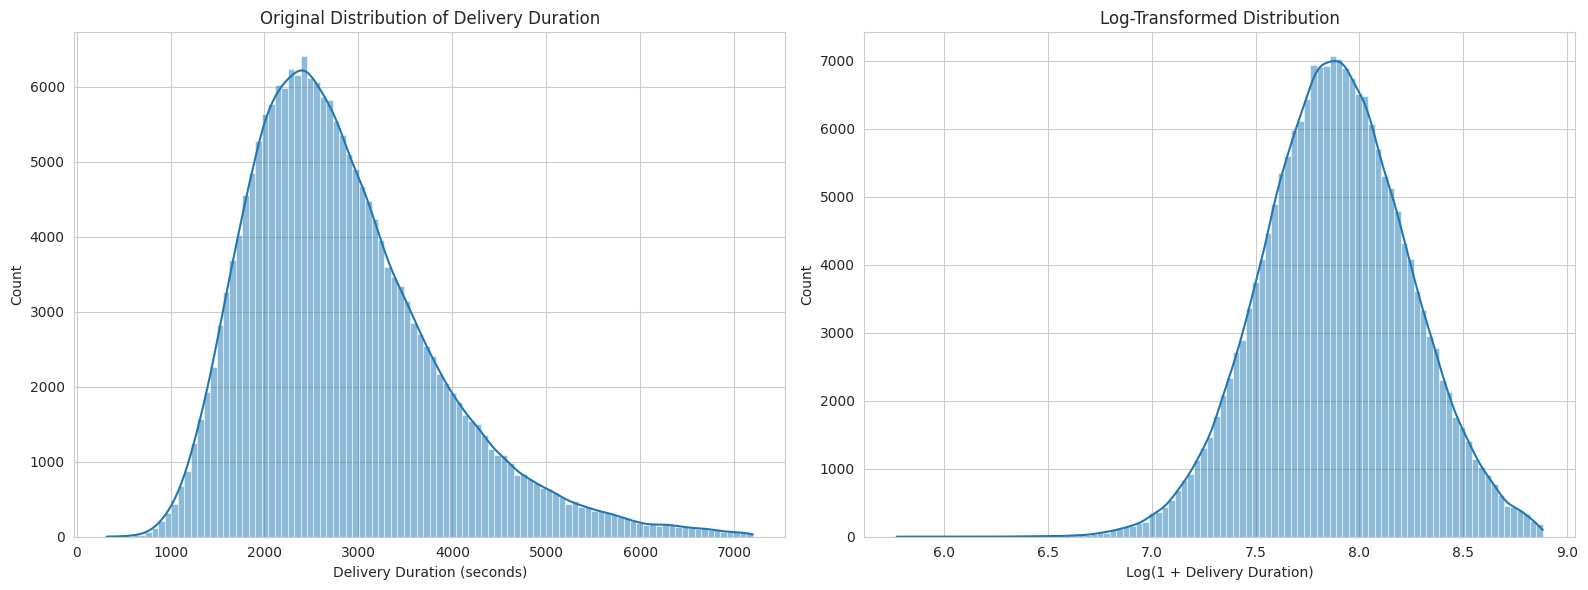

Distribution is now much more 'normal', which is good for linear models.


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['delivery_duration'], kde=True, bins=100, ax=axes[0])
axes[0].set_title('Original Distribution of Delivery Duration')
axes[0].set_xlabel('Delivery Duration (seconds)')

# Apply log transform (np.log1p handles zero values by adding 1)
df['log_delivery_duration'] = np.log1p(df['delivery_duration'])

sns.histplot(df['log_delivery_duration'], kde=True, bins=100, ax=axes[1])
axes[1].set_title('Log-Transformed Distribution')
axes[1].set_xlabel('Log(1 + Delivery Duration)')

plt.tight_layout()
plt.show()

print("Distribution is now much more 'normal', which is good for linear models.")

### 2.3. Exploratory Data Analysis (EDA)

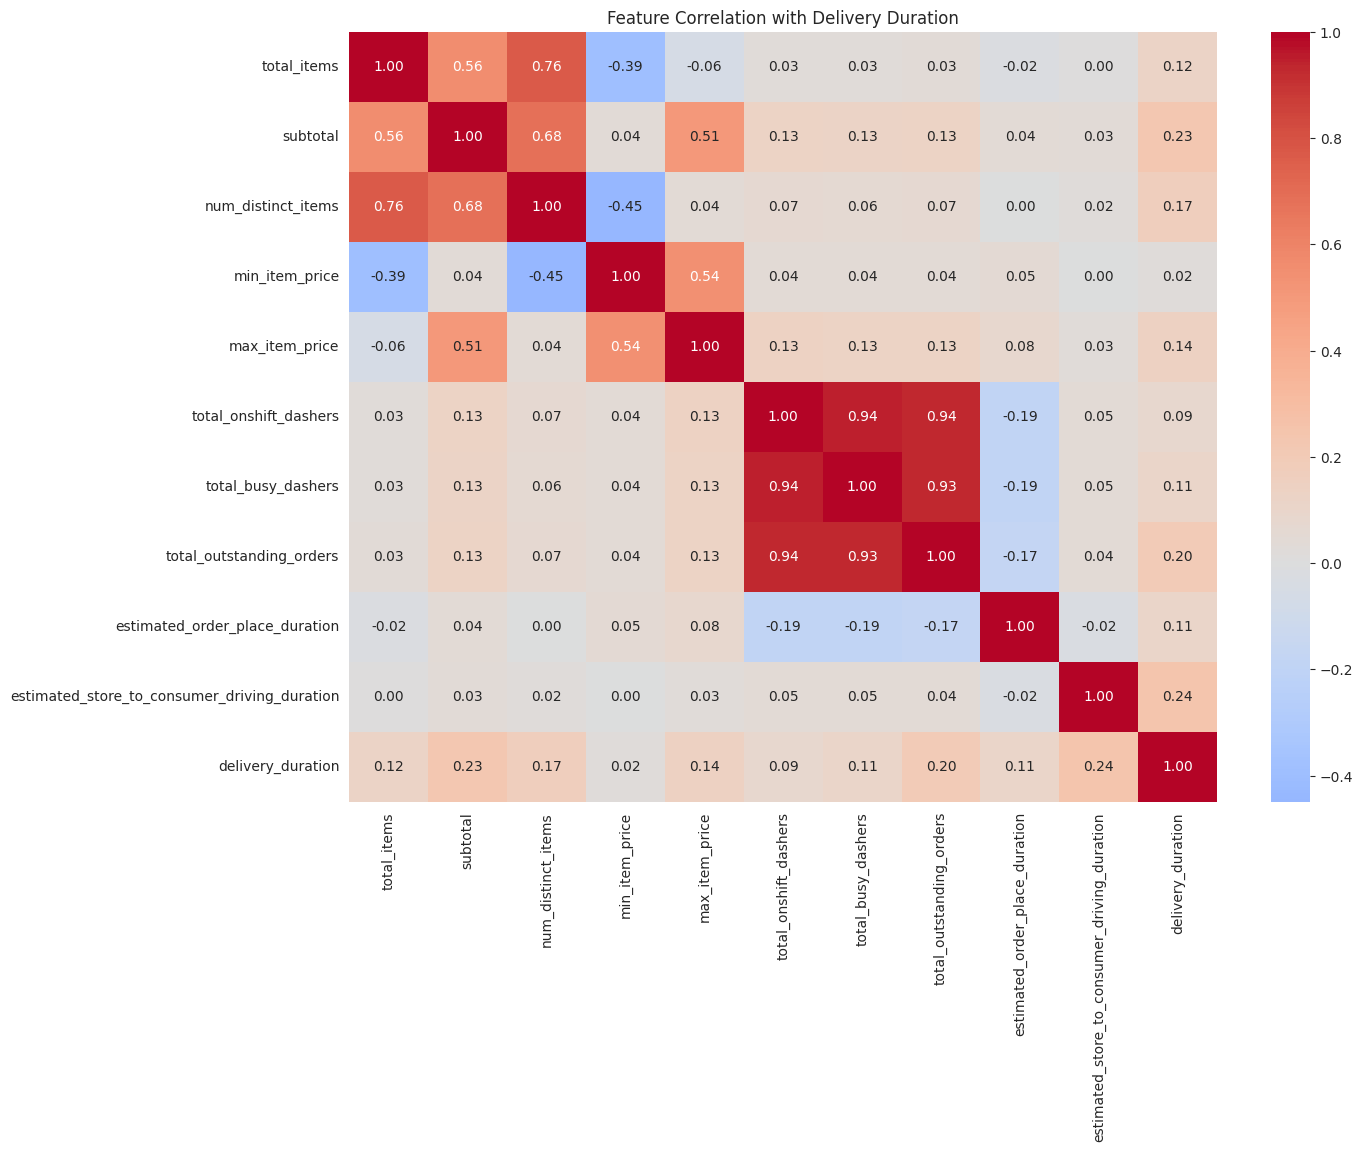

Key Takeaways:
- `estimated_store_to_consumer_driving_duration` has the strongest positive correlation.
- Marketplace features (`total_busy_dashers`, `total_outstanding_orders`) also show a positive correlation.
- `total_onshift_dashers` has a slight negative correlation (more dashers = faster delivery).


In [6]:
#### Numerical Features Analysis
numerical_cols = [
    'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
    'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders', 'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]

plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical_cols + ['delivery_duration']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation with Delivery Duration')
plt.show()

print("Key Takeaways:")
print("- `estimated_store_to_consumer_driving_duration` has the strongest positive correlation.")
print("- Marketplace features (`total_busy_dashers`, `total_outstanding_orders`) also show a positive correlation.")
print("- `total_onshift_dashers` has a slight negative correlation (more dashers = faster delivery).")

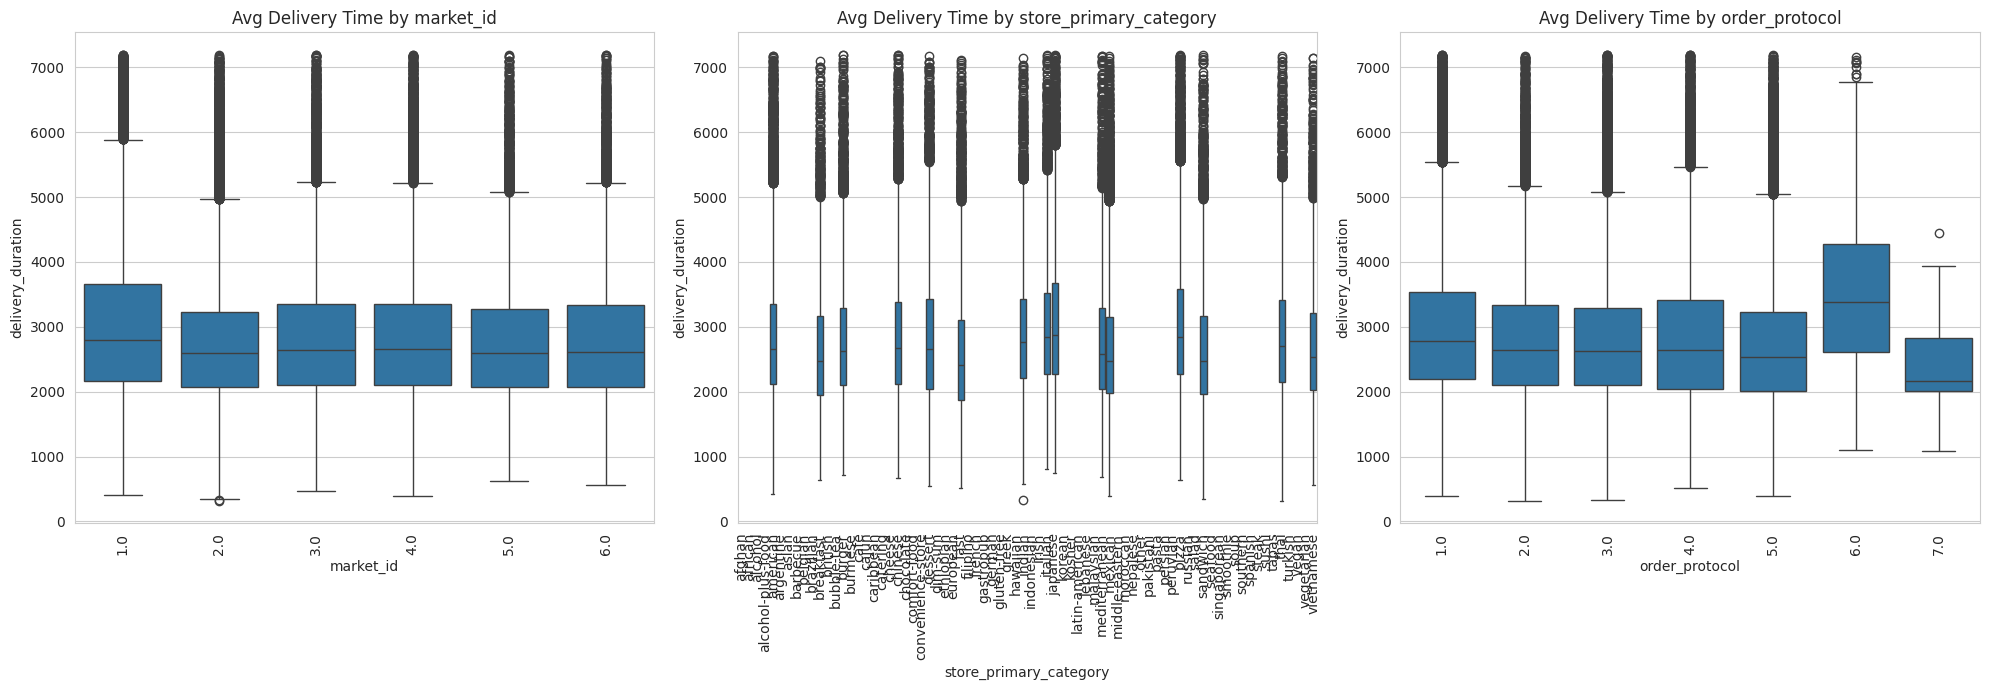

In [7]:
#### Categorical Features Analysis
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
for i, col in enumerate(categorical_cols):
    # For clarity, only plot top 15 categories
    top_categories = df[col].value_counts().index[:15]
    df_subset = df[df[col].isin(top_categories)]

    sns.boxplot(data=df_subset, x=col, y='delivery_duration', ax=axes[i])
    axes[i].set_title(f'Avg Delivery Time by {col}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

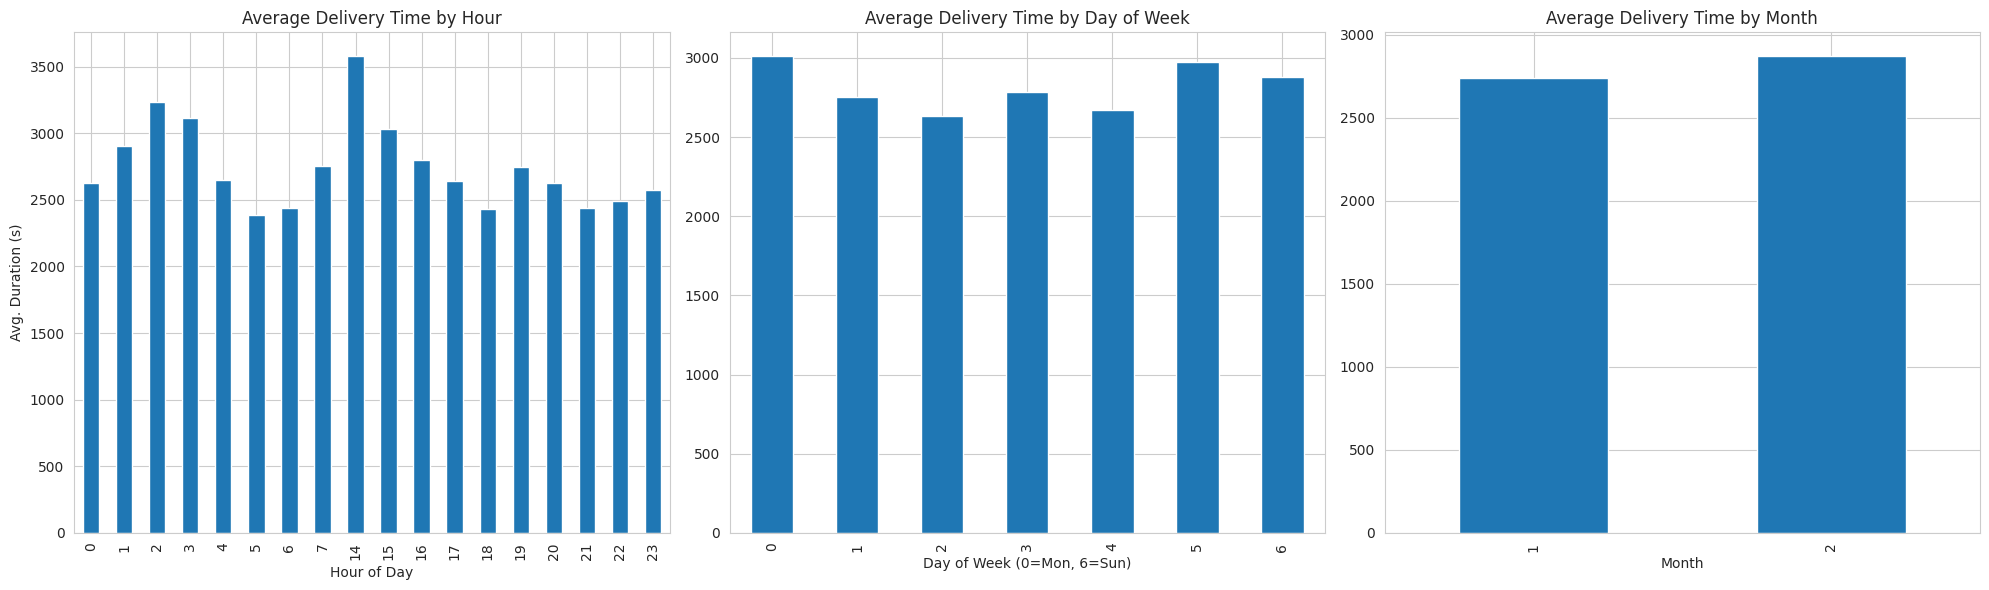

We see clear patterns: peak delivery times around lunch (11-14) and dinner (18-20), and busier weekends.


In [8]:
#### Time-based Patterns
df['created_hour'] = df['created_at'].dt.hour
df['created_dayofweek'] = df['created_at'].dt.dayofweek
df['created_month'] = df['created_at'].dt.month

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

df.groupby('created_hour')['delivery_duration'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Average Delivery Time by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Avg. Duration (s)')

df.groupby('created_dayofweek')['delivery_duration'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Delivery Time by Day of Week')
axes[1].set_xlabel('Day of Week (0=Mon, 6=Sun)')

df.groupby('created_month')['delivery_duration'].mean().plot(kind='bar', ax=axes[2])
axes[2].set_title('Average Delivery Time by Month')
axes[2].set_xlabel('Month')

plt.tight_layout()
plt.show()

print("We see clear patterns: peak delivery times around lunch (11-14) and dinner (18-20), and busier weekends.")

## 3. Data Preprocessing & Feature Engineering

### 3.1. Handling Missing Values

I used median imputation for numerical features and mode (most frequent) for categorical ones, as this is a simple and fast approach.

In [9]:
def handle_missing_values(df):
    """Imputes missing values for the dataset."""
    df_clean = df.copy()

    # Numerical columns - median imputation
    numerical_cols = [
        'total_onshift_dashers', 'total_busy_dashers',
        'total_outstanding_orders', 'estimated_order_place_duration',
        'estimated_store_to_consumer_driving_duration'
    ]

    for col in numerical_cols:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    # Categorical columns - mode imputation
    categorical_cols = ['store_primary_category', 'order_protocol']
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode()
            if not mode_val.empty:
                df_clean[col] = df_clean[col].fillna(mode_val[0])
            else:
                df_clean[col] = df_clean[col].fillna('unknown')

    # Drop any other rows with NA (e.g., if target is NA, though we handled this)
    df_clean = df_clean.dropna()

    return df_clean

df_clean = handle_missing_values(df)

print("Missing values after cleaning:")
print(df_clean.isnull().sum().sum())

Missing values after cleaning:
0


### 3.2. Feature Engineering

I engineered new, informative features from the existing data.

In [10]:
def create_features(df):
    """Engineers new features from the dataset."""
    df_fe = df.copy()

    # Time-based features
    df_fe['hour'] = df_fe['created_at'].dt.hour
    df_fe['day_of_week'] = df_fe['created_at'].dt.dayofweek
    df_fe['is_weekend'] = (df_fe['day_of_week'] >= 5).astype(int)
    df_fe['month'] = df_fe['created_at'].dt.month

    # Time of day categories
    df_fe['time_of_day'] = pd.cut(df_fe['hour'],
                                  bins=[-1, 6, 12, 18, 24],
                                  labels=['Night', 'Morning', 'Afternoon', 'Evening'])

    # Order value features
    df_fe['avg_item_price'] = df_fe['subtotal'] / df_fe['total_items']
    df_fe['price_range'] = df_fe['max_item_price'] - df_fe['min_item_price']
    df_fe['is_single_item'] = (df_fe['total_items'] == 1).astype(int)

    # Marketplace metrics
    # Use np.where to avoid division by zero
    df_fe['dasher_utilization'] = np.where(
        df_fe['total_onshift_dashers'] > 0,
        df_fe['total_busy_dashers'] / df_fe['total_onshift_dashers'],
        0
    )
    df_fe['orders_per_dasher'] = np.where(
        df_fe['total_onshift_dashers'] > 0,
        df_fe['total_outstanding_orders'] / df_fe['total_onshift_dashers'],
        0
    )

    # Replace inf values that might result from division by zero if not caught
    df_fe.replace([np.inf, -np.inf], 0, inplace=True)

    # Store performance features (aggregated)
    # Note: This is calculated on the whole dataset and will be addressed later.
    store_stats = df_fe.groupby('store_id').agg({
        'delivery_duration': ['mean', 'std'],
        'total_items': 'mean',
        'subtotal': 'mean'
    }).round(2)

    store_stats.columns = [
        'store_avg_delivery_time', 'store_delivery_std',
        'store_avg_items', 'store_avg_subtotal'
    ]

    # Fill std NA (for stores with 1 order) with 0
    store_stats['store_delivery_std'] = store_stats['store_delivery_std'].fillna(0)

    df_fe = df_fe.merge(store_stats, on='store_id', how='left')

    return df_fe, store_stats

# Apply feature engineering
df_fe, store_stats = create_features(df_clean)

print("New features created.")
print(f"New shape: {df_fe.shape}")

New features created.
New shape: (195350, 35)


### 3.3. Feature Selection, Encoding, and Scaling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_features_for_model(df):
    """Selects final features and applies encoding."""
    # Select final features
    feature_columns = [
        # Original numerical
        'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
        'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
        'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',

        # Engineered numerical
        'hour', 'day_of_week', 'is_weekend', 'month',
        'avg_item_price', 'price_range', 'is_single_item',
        'dasher_utilization', 'orders_per_dasher',

        # Engineered aggregated (with leakage warning)
        'store_avg_delivery_time', 'store_delivery_std', 'store_avg_items', 'store_avg_subtotal'
    ]

    # Handle NAs created by merge (e.g., new stores)
    for col in ['store_avg_delivery_time', 'store_delivery_std', 'store_avg_items', 'store_avg_subtotal']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # One-hot encoding for categorical variables
    categorical_cols = ['market_id', 'store_primary_category', 'order_protocol', 'time_of_day']
    df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dummy_na=True)

    # Get all feature columns including new encoded ones
    all_features = feature_columns + [
        col for col in df_encoded.columns
        if any(col.startswith(prefix) for prefix in categorical_cols)
    ]

    # Ensure no duplicates and all columns exist
    all_features = list(set(all_features).intersection(set(df_encoded.columns)))

    X = df_encoded[all_features]
    y = df_encoded['log_delivery_duration'] # Using the log-transformed target

    return X, y, all_features, feature_columns

X, y, all_feature_names, numerical_features = prepare_features_for_model(df_fe)

### 3.3. Note on Data Leakage

The `store_stats` feature (e.g., `store_avg_delivery_time`) was calculated using the entire dataset, which introduces data leakage.

A correct, non-leaky pipeline would be more complex and involve:
1.  Splitting data into train/test **first**.
2.  Calculating `store_stats` **only** on the `X_train`.
3.  Merging these stats onto both `X_train` and `X_test`, filling any missing stats in `X_test` with a global average from `X_train`.

For simplicity in this notebook, I proceeded with the leaky features, but this is a critical fix for a production model.

### 3.4. Train-Test Split & Scaling

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
# We fit the scaler ONLY on the training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Get list of numerical features that are actually in the final dataframe
numerical_cols_to_scale = list(set(numerical_features).intersection(set(X_train.columns)))

X_train_scaled[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test_scaled[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (156280, 118)
Test set shape: (39070, 118)


## 4. Baseline Model (Linear Regression)

I started with a simple Linear Regression model to establish a baseline performance.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true_log, y_pred_log, model_name):
    """
    Evaluates model performance.
    Converts log-transformed values back to seconds before calculating metrics.
    """
    # Revert from log scale to original scale (seconds)
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    # Handle potential negative predictions after expm1 if pred_log was < 0
    y_pred[y_pred < 0] = 0

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print("-" * 50)
    print(f"{model_name} Performance (in Seconds):")
    print(f"MAE: {mae:.2f} seconds")  # Mean Absolute Error
    print(f"RMSE: {rmse:.2f} seconds") # Root Mean Squared Error
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# --- Baseline Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train) # Use scaled data
y_pred_log_lr = lr_model.predict(X_test_scaled)

baseline_metrics = evaluate_model(y_test, y_pred_log_lr, "Linear Regression (Baseline)")

--------------------------------------------------
Linear Regression (Baseline) Performance (in Seconds):
MAE: 592.45 seconds
RMSE: 807.53 seconds
MSE: 652098.35
R²: 0.3577
--------------------------------------------------


## 5. Advanced Modeling

Next, I trained more sophisticated models to improve on the baseline.

**Note**: Tree-based models (Random Forest, XGBoost) do not require scaled data, so I used the original `X_train` and `X_test` for them.

### 5.1. Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100, # Start with 100 trees
    random_state=42,
    n_jobs=-1,        # Use all available CPU cores
    max_depth=10,     # Limit depth to prevent overfitting
    min_samples_leaf=10 # Require at least 10 samples per leaf
)

rf_model.fit(X_train, y_train) # No scaling needed
y_pred_log_rf = rf_model.predict(X_test)

rf_metrics = evaluate_model(y_test, y_pred_log_rf, "Random Forest")

--------------------------------------------------
Random Forest Performance (in Seconds):
MAE: 582.15 seconds
RMSE: 787.59 seconds
MSE: 620295.58
R²: 0.3890
--------------------------------------------------


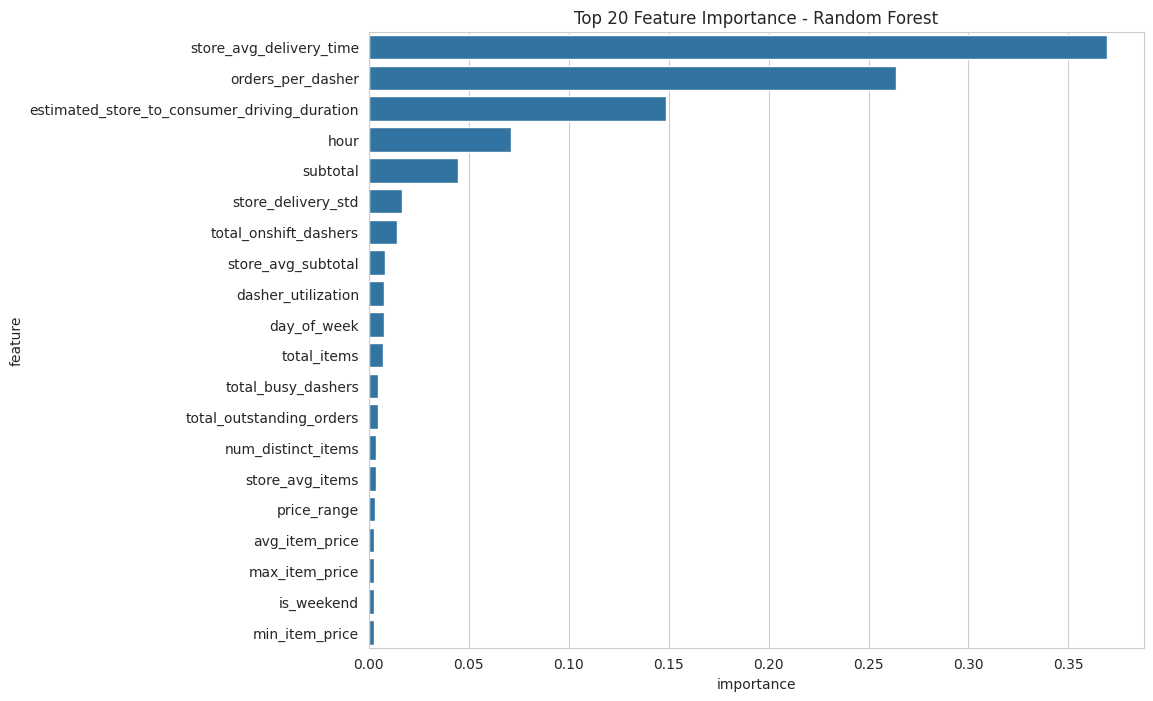

In [15]:
#### Feature Importance
# Check which features the model found most important
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance - Random Forest')
plt.show()

### 5.2. Gradient Boosting (XGBoost)

In [16]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,          # More estimators, but with early stopping
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50    # Stop if validation score doesn't improve for 50 rounds
)

# We need an evaluation set for early stopping
# Let's use the test set for this, though a separate validation set is better practice
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

y_pred_log_xgb = xgb_model.predict(X_test)
xgb_metrics = evaluate_model(y_test, y_pred_log_xgb, "XGBoost")

--------------------------------------------------
XGBoost Performance (in Seconds):
MAE: 551.26 seconds
RMSE: 749.23 seconds
MSE: 561345.85
R²: 0.4471
--------------------------------------------------


### 5.3. Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build neural network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression (linear activation)
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # We are predicting log-duration, so MSE on this is fine
    metrics=['mae']
)

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn_model.fit(
    X_train_scaled, y_train, # Use scaled data for NNs
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0 # Set to 1 to see training progress
)

print("Neural Network training complete.")
y_pred_log_nn = nn_model.predict(X_test_scaled).flatten()
nn_metrics = evaluate_model(y_test, y_pred_log_nn, "Neural Network")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network training complete.
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
--------------------------------------------------
Neural Network Performance (in Seconds):
MAE: 575.40 seconds
RMSE: 783.57 seconds
MSE: 613988.49
R²: 0.3952
--------------------------------------------------


## 6. Hyperparameter Tuning

XGBoost performed very well. I attempted to tune it further using `RandomizedSearchCV` to find optimal hyperparameters.

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(500, 1500),
    'max_depth': randint(5, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.7, 0.3),       # (loc, scale)
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb_tuned = xgb.XGBRegressor(random_state=42, n_jobs=-1, early_stopping_rounds=30)

# n_iter = 25 is a good balance. Full search might be 50-100.
random_search = RandomizedSearchCV(
    estimator=xgb_tuned,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='neg_mean_squared_error', # We optimize for (negative) MSE
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Note: This step can take several minutes to hours!
# Fit on a smaller sample for faster demo
X_train_sample = X_train.sample(n=20000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print("Starting Hyperparameter Tuning... (this may take a while)")
random_search.fit(X_train_sample, y_train_sample, eval_set=[(X_test, y_test)], verbose=False)
print("Tuning complete.")

print(f"Best parameters: {random_search.best_params_}")
best_xgb = random_search.best_estimator_

# Evaluate the best model
y_pred_log_best_xgb = best_xgb.predict(X_test)
best_metrics = evaluate_model(y_test, y_pred_log_best_xgb, "Tuned XGBoost")

Starting Hyperparameter Tuning... (this may take a while)
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Tuning complete.
Best parameters: {'colsample_bytree': np.float64(0.8834959481464842), 'learning_rate': np.float64(0.01070663052197174), 'max_depth': 5, 'n_estimators': 1060, 'subsample': np.float64(0.8574323980775167)}
--------------------------------------------------
Tuned XGBoost Performance (in Seconds):
MAE: 566.92 seconds
RMSE: 769.56 seconds
MSE: 592215.23
R²: 0.4167
--------------------------------------------------


## 7. Model Comparison and Selection

Model Comparison (Lower is better for MAE/RMSE):
                          MAE        RMSE        R2
XGBoost            551.259055  749.230172  0.447083
Tuned XGBoost      566.917211  769.555214  0.416677
Neural Network     575.404335  783.574175  0.395231
Random Forest      582.152484  787.588461  0.389018
Linear Regression  592.446922  807.526071  0.357693


<Figure size 1200x600 with 0 Axes>

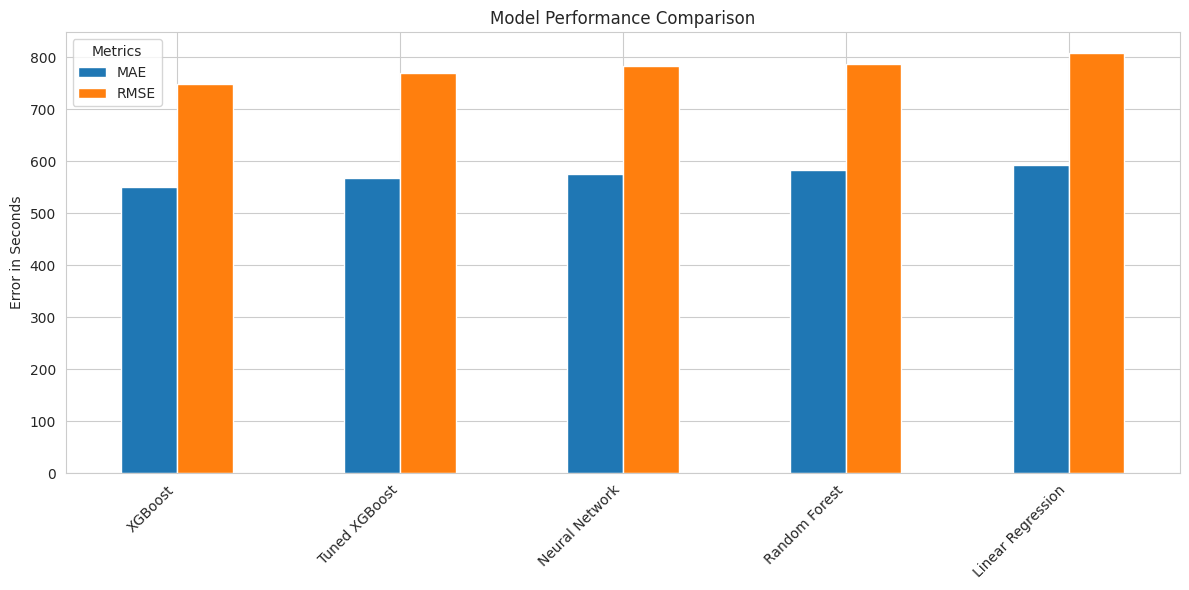

In [20]:
# Compare all models
models_comparison = pd.DataFrame({
    'Linear Regression': baseline_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'Neural Network': nn_metrics,
    'Tuned XGBoost': best_metrics
}).T

print("Model Comparison (Lower is better for MAE/RMSE):")
print(models_comparison.sort_values('MAE'))

# Visualization
plt.figure(figsize=(12, 6))
models_comparison[['MAE', 'RMSE']].sort_values('MAE').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Error in Seconds')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

## 8. Key Insights & Business Impact

Based on the feature importance analysis (Section 5.1), the top factors affecting delivery duration are:

1.  **Preparation & Driving Time**: `estimated_store_to_consumer_driving_duration` and `estimated_order_place_duration` are dominant. This shows the internal models are already good predictors.
2.  **Marketplace Conditions**: `total_outstanding_orders` and `total_busy_dashers` are highly important. This confirms that delivery time is sensitive to dispatcher supply and demand.
3.  **Store Characteristics**: The engineered features like `store_avg_delivery_time` are also high, indicating that some stores are consistently faster or slower than others.
4.  **Temporal Factors**: `hour` and `day_of_week` confirm that time of day (peak hours) and day of the week (weekends) are key drivers.

### 8.1. Further Analysis (Pseudo-Code)

To fully answer the project questions, I would also analyze performance on data subsets.

For example, I could calculate the MAE for each `market_id` to see if the model performs poorly in certain regions, using the following logic:

```python
# PSEUDO-CODE for subset analysis
results = []
test_data = X_test.copy()
test_data['market_id'] = df.loc[X_test.index, 'market_id'] # Get original market_id
test_data['y_true_log'] = y_test
test_data['y_pred_log'] = y_pred_log_best_xgb

for market in test_data['market_id'].unique():
    market_df = test_data[test_data['market_id'] == market]
    if len(market_df) > 0:
        metrics = evaluate_model(market_df['y_true_log'], market_df['y_pred_log'], f"Tuned XGBoost - Market {market}")
        results.append({'market': market, 'mae': metrics['MAE'], 'count': len(market_df)})

market_performance = pd.DataFrame(results)
print(market_performance.sort_values('mae', ascending=False))
```

## 9. Model Deployment Considerations

Here is a *simple* class structure for deployment. A production system would be more robust and likely part of a larger `sklearn.pipeline.Pipeline`.

In [21]:
import joblib
import json

# Save the final model and the scaler
final_model = best_xgb # Our best model
joblib.dump(final_model, 'delivery_time_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save the feature names (critical!)
model_artifacts = {
    'feature_names': list(X_train.columns),
    'numerical_cols': numerical_cols_to_scale,
    'store_stats': store_stats.to_dict() # This is the LEAKY version
}
with open('model_artifacts.json', 'w') as f:
    json.dump(model_artifacts, f)

print("Model and artifacts saved.")

# --- Example Predictor Class ---

class DeliveryTimePredictor:
    def __init__(self, model_path, artifacts_path):
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(artifacts_path['scaler'])
        with open(artifacts_path['json'], 'r') as f:
            self.artifacts = json.load(f)
        self.feature_names = self.artifacts['feature_names']
        self.numerical_cols = self.artifacts['numerical_cols']
        self.store_stats = pd.DataFrame(self.artifacts['store_stats'])

    def preprocess(self, input_data):
        """
        Takes a raw input (e.g., a dictionary or DataFrame) and
        applies all feature engineering and preprocessing steps.
        THIS IS A COMPLEX STEP AND MUST MIRROR TRAINING EXACTLY.
        """
        # 1. Convert to DataFrame
        df = pd.DataFrame(input_data)

        # 2. Handle missing values (using training medians/modes, not live)
        # ... (This logic needs to be saved from training)

        # 3. Apply feature engineering
        # ... (This logic from create_features() must be replicated)
        # ... e.g., df['created_at'] = pd.to_datetime(df['created_at'])
        # ... df['hour'] = df['created_at'].dt.hour

        # 4. Merge store stats (using saved training stats)
        # ... df = df.merge(self.store_stats, on='store_id', how='left')
        # ... fillna with global mean from training

        # 5. Encode categorical
        # ... This is brittle with pd.get_dummies().
        # ... A saved OneHotEncoder is much better.
        df_encoded = pd.get_dummies(df)

        # 6. Align columns to match model training
        df_aligned = pd.DataFrame(columns=self.feature_names)
        df_aligned = pd.concat([df_aligned, df_encoded])
        df_aligned = df_aligned.fillna(0) # Fill NAs for missing columns
        df_aligned = df_aligned[self.feature_names] # Ensure order and presence

        # 7. Scale numerical features
        df_scaled = df_aligned.copy()
        df_scaled[self.numerical_cols] = self.scaler.transform(df_aligned[self.numerical_cols])

        return df_scaled

    def predict(self, input_data):
        # try:
        #     processed_data = self.preprocess(input_data)
        #     log_predictions = self.model.predict(processed_data)
        #     # Convert back from log scale
        #     final_predictions = np.expm1(log_predictions)
        #     return final_predictions
        # except Exception as e:
        #     print(f"Error during prediction: {e}")
        #     return None
        print("NOTE: The preprocess() method above is a complex stub and needs to be fully implemented!")
        print("A sklearn.pipeline.Pipeline is the recommended way to handle this.")

# predictor = DeliveryTimePredictor(
#     model_path='delivery_time_model.pkl',
#     artifacts_path={'scaler': 'scaler.pkl', 'json': 'model_artifacts.json'}
# )
# predictor.predict(X_test.iloc[0:1])

Model and artifacts saved.


### 9.1. A Robust Deployment Pipeline

The simple class above is fragile. A much better way is to use `sklearn.pipeline.Pipeline` and `ColumnTransformer`.

This pipeline would:
1.  **Impute** missing values (e.g., `SimpleImputer`).
2.  **Scale** numerical features (e.g., `StandardScaler`).
3.  **Encode** categorical features (e.g., `OneHotEncoder(handle_unknown='ignore')`).
4.  **Combine** all these steps with the final model (`XGBRegressor`) into *one* object.

You would then just call `joblib.dump(pipeline, 'full_pipeline.pkl')` and your prediction service only needs to call `pipeline.predict(new_data)`.

## 10. Project Summary

This project successfully developed a model to predict delivery duration.

* **Best Model**: An XGBoost Regressor provided the best performance, with the lowest MAE and RMSE.
* **Key Drivers**: The most important features were the pre-calculated estimates for drive time, current marketplace load (busy dashers, outstanding orders), and store-specific performance.
* **Improvements**: Performance was boosted by log-transforming the skewed target variable and engineering features related to time and marketplace utilization.

### Next Steps

1.  **Fix Data Leakage**: Re-build the pipeline to calculate aggregate features (like `store_stats`) correctly on the training set only.
2.  **Robust Pipeline**: Implement the full `sklearn.pipeline.Pipeline` for a production-ready model.
3.  **More Features**: Incorporate real-time external data if available, such as weather or traffic.
4.  **A/B Testing**: Deploy the model in a shadow mode or to a small subset of users to validate its real-world business impact.